In [1]:
import os
import glob
import pickle
import datetime
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special
# Library to perform MCMC runs
import emcee

import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner

# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 1.5, 
    'axes.labelsize' : 16, 
    'axes.titlesize' : 18,
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13,
    'grid.linestyle' : ':',
    'grid.color' : 'a6a6a6'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Generate a variable with the day that the script is run
today = str(datetime.datetime.today().strftime('%Y%m%d'))

# Effect of the $\Delta \epsilon_{ai}$ parameter on the fit.

One of the main concerns in the project so far has been the lack of an independent measurement of the "allosteric parameter" $\Delta \epsilon_{ai}$.

There have been several proposals of how could we potentially extract this parameter from the different versions of the lacI titration curves that the lab has been working on over the last $\approx$ 10 years, but so far we haven't found a clear methodology for how to nail the value of this parameter.

But an interesting question itelf is what is the effect that the parameter would have on the other two MWC parameters $K_A$ and $K_I$. For this we can peform a systematic fit of these two parameters allowing $\Delta \epsilon_{ai}$ vary along reasonable ranges. The intuition is that the only constraint we can put on the parameter is that it should be $\geq 0 k_BT$ since we assume there should be an energetic cost to change to the inactive conformation.

Let's explore this issue.

First let's read the data.

In [2]:
datadir = '../../data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*' + 'O2_IPTG_titration' + '*csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of independent data-sets: {:d}'.format(len(read_files)))
df = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

df.head()

Number of independent data-sets: 11


,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
2,20160804,mrazomej,O2,-13.9,RBS1L,870,0.0,3624.474605,111.851286,0.007146
3,20160804,mrazomej,O2,-13.9,RBS1,610,0.0,3619.786265,107.162946,0.006847
4,20160804,mrazomej,O2,-13.9,RBS1027,130,0.0,3717.019527,204.396208,0.013059
5,20160804,mrazomej,O2,-13.9,RBS446,62,0.0,3854.650585,342.027265,0.021853
6,20160804,mrazomej,O2,-13.9,RBS1147,30,0.0,4169.802851,657.179531,0.041988


Now let's peform the systematic fitting to differnt values of $\Delta \epsilon_{ai}$

In [3]:
# define the range of epsilons to use
epsilon_array = np.linspace(0, 20, 50) # kBT

# define the data-set to use ignoring the WT.
df_fit = df[df.rbs!='HG104']

# initialize a data frame to save the regression parameters
param_df = pd.DataFrame()
# loop through the epsilon performing the regression
for i, epsilon in enumerate(epsilon_array):
    param =  pd.Series(mwc.non_lin_reg_mwc(df_fit, p0=[1, 1], epsilon=epsilon, 
                                       diss_const=False), 
                       index=['ea', 'delta_ea', 'ei', 'delta_ei'])
    param_df = pd.concat([param_df, param], axis=1)
# rename the columns by the value of epsilon
param_df.columns = epsilon_array

Once we peform the regression let's look at the value of the parametres as a function of the allosteric parameter.

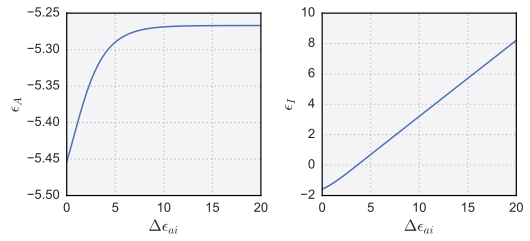

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.5))
# plot for e_A
ax[0].plot(param_df.columns, param_df.T['ea'])
ax[0].set_xlabel(r'$\Delta \epsilon_{ai}$')
ax[0].set_ylabel(r'$\epsilon_A$')

# plot for e_I
ax[1].plot(param_df.columns, param_df.T['ei'])
ax[1].set_xlabel(r'$\Delta \epsilon_{ai}$')
ax[1].set_ylabel(r'$\epsilon_I$')
plt.tight_layout()

So the regression indeed found a set of parameters $\epsilon_A$ and $\epsilon_I$ for each value of $\Delta\epsilon_{ai}$. But there is something strange about the error bar on the parameters. Let's explore this issue by ploting the error $\delta \epsilon_A$ and $\delta \epsilon_I$ as a function of the allosteric parameter.

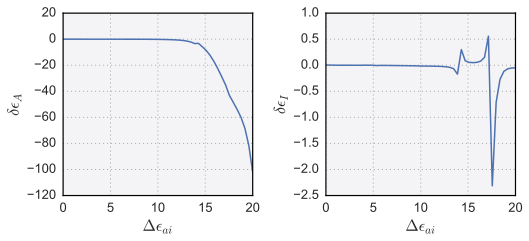

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.5))
# plot for delta_e_A
ax[0].plot(param_df.columns, param_df.T['delta_ea'])
ax[0].set_xlabel(r'$\Delta \epsilon_{ai}$')
ax[0].set_ylabel(r'$\delta \epsilon_A$')

# plot for delta_e_I
ax[1].plot(param_df.columns, param_df.T['delta_ei'])
ax[1].set_xlabel(r'$\Delta \epsilon_{ai}$')
ax[1].set_ylabel(r'$\delta \epsilon_I$')
plt.tight_layout()

The error seems to diverge when $\Delta\epsilon_{ai}$ is around 13 $k_BT$. This could mean that the assumption that the posterior can be approximated as a Gaussian breaks at this region of parameter space.

A way to explore this is to use MCMC to "explore" the posterior and see what's happening here.

Let's set up an MCMC sampler.

### $\Delta\epsilon_{ai} = 15\; k_BT$

In [6]:
# extracting independent and dependent variables
indep_var = df[['IPTG_uM', 'repressors', 'binding_energy']]
dep_var = df.fold_change_A

# Perform a non-linear regression to initialize walkers
map_param =  mwc.non_lin_reg_mwc(df, p0=[1, 7],epsilon=15, diss_const=False)
mean = [map_param[0], map_param[2]]
cov = np.array([[np.abs(map_param[1]), 0], [0, np.abs(map_param[3])]])

# We will use an arbitrary covariance matrix since we know the error on this
# region of parameter space is diverging
# cov = np.array([[1, 0], [0, 1]])

In [7]:
#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 1000
n_burn = 1000
n_steps = 10000

# Initialize walkers
p0 = np.empty((n_walkers, n_dim))
p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov, n_walkers)
p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)

In [8]:
# Set the ranges for the MCMC
ea_range = [-6, 9]
ei_range = [-6, 9]
sigma_range = [0, 20]
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, mwc.log_post_mcmc,\
                args=(indep_var, dep_var, 15, ea_range, ei_range, sigma_range),\
                threads=6)

In [9]:
sample = False 
if sample:
    #Do the burn in
    print('Performing burn in')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    print('Performing MCMC')
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/' + today + \
                  '_gauss_homoscedastic_pool_data_epsilon15.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)
    pickle.dump(ea_range, output)
    pickle.dump(ei_range, output)
    pickle.dump(sigma_range, output)

Performing burn in
Performing MCMC


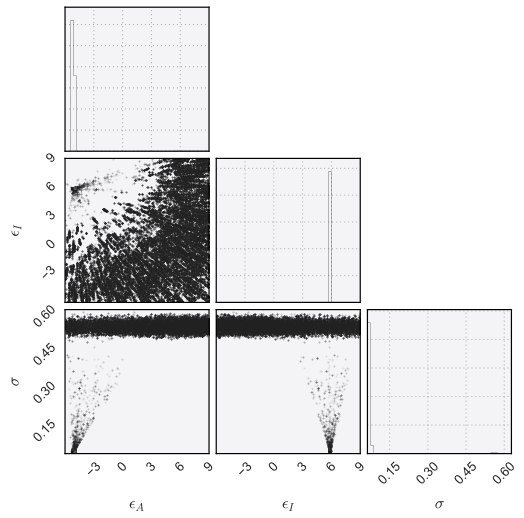

In [12]:
# read the flat-chain
with open('../../data/mcmc/' + '20160817' + \
                  '_gauss_homoscedastic_pool_data_epsilon15.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_pool_flatchain = unpickler.load()

# plot the corner plot
fig = corner.corner(gauss_pool_flatchain, bins=50, plot_contours=False,
                   labels=[r'$\epsilon_A$', r'$\epsilon_I$', r'$\sigma$'])

This is really strange. What we are seeing here is that when the allosteric parameter has a value of 1 $k_BT$ the posterior probabilities for the $\epsilon_A$ and $\epsilon_I$ look like a delta function, meaning that there is no space for variability for these parameters.

That itself has a clear prediciton. If I plot the curves using the MAP values I should be able to reproduce the data, but if I use instead $\epsilon_X + \delta \epsilon_X$, where $\lvert \delta \epsilon_X \rvert \ll \lvert \epsilon_X \rvert$ the fold-change curve should radically change.

Let's look if that is the case. We will be plotting $p_{act}(C)$ with slight variations of the parameters.

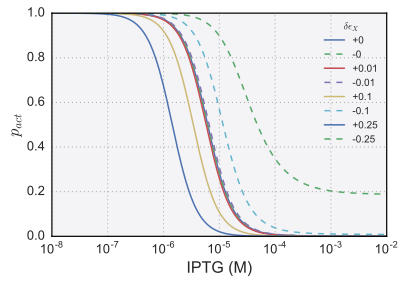

In [23]:
epsilon= 15
# Fit the parameters using epsilon = 15
ea, delta_ea, ei, delta_ei = mwc.non_lin_reg_mwc(df_fit, p0=[1, 1], 
                                                 epsilon=epsilon, 
                                                 diss_const=False)

# determine the IPTG range
IPTG = np.logspace(-8, -2, 200) # M
variability = [0, 0.01, 0.1, 0.25]

# loop through the variability to plot the figure
plt.figure()
for var in variability:
    ea_plus, ei_plus = ea + ea * var, ei + ei * var
    ea_minus, ei_minus = ea - ea * var, ei - ei * var
    plt.plot(IPTG, mwc.pact_log(IPTG * 1E6, ea_plus, ei_plus, epsilon),
            label='+' + str(var))
    plt.plot(IPTG, mwc.pact_log(IPTG * 1E6, ea_minus, ei_minus, epsilon),
            label='-' + str(var), linestyle='--')
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel(r'$p_{act}$')
plt.legend(title=r'$\delta\epsilon_X$')

Let's compare that to when we do the regression using $\Delta\epsilon_{ai}=4.5\; k_BT$

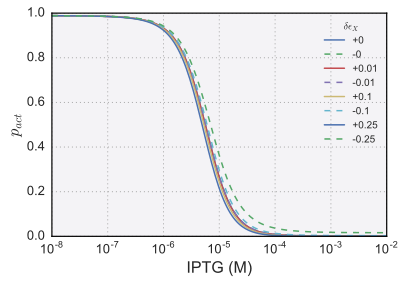

In [24]:
epsilon= 4.5
# Fit the parameters using epsilon = 15
ea, delta_ea, ei, delta_ei = mwc.non_lin_reg_mwc(df_fit, p0=[1, 1], 
                                                 epsilon=epsilon, 
                                                 diss_const=False)

# determine the IPTG range
IPTG = np.logspace(-8, -2, 200) # M
variability = [0, 0.01, 0.1, 0.25]

# loop through the variability to plot the figure
plt.figure()
for var in variability:
    ea_plus, ei_plus = ea + ea * var, ei + ei * var
    ea_minus, ei_minus = ea - ea * var, ei - ei * var
    plt.plot(IPTG, mwc.pact_log(IPTG * 1E6, ea_plus, ei_plus, epsilon),
            label='+' + str(var))
    plt.plot(IPTG, mwc.pact_log(IPTG * 1E6, ea_minus, ei_minus, epsilon),
            label='-' + str(var), linestyle='--')
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel(r'$p_{act}$')
plt.legend(title=r'$\delta\epsilon_X$')

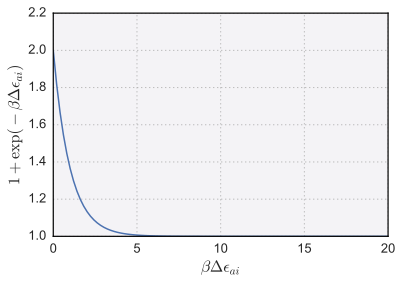

In [29]:
plt.plot(np.linspace(0, 20, 100), 1 + np.exp(- np.linspace(0, 20, 100)))
plt.xlabel(r'$\beta \Delta\epsilon_{ai}$')
plt.ylabel(r'$1 + \exp (- \beta \Delta \epsilon_{ai})$')